# OCR cyrillic

## Imports

In [1]:
# !pip install "python-doctr[torch,viz,html,contrib]"

In [14]:
import gc
import re
import json
import random
from itertools import chain
from tqdm.auto import tqdm
import difflib

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import cv2

import torch
from doctr.io import DocumentFile
from doctr.models import ocr_predictor, recognition, detection

from torchmetrics.text import CharErrorRate, WordErrorRate
from torchmetrics.functional.text import char_error_rate, word_error_rate
import Levenshtein

from castom_utils import *

In [88]:
def calculation_score_doctr(model, path_dataset):
    """
    Расчет Levenshtein distance и Levenshtein ratio
    """
    gc.collect()
    torch.cuda.empty_cache()
    
    with open(path_dataset.joinpath('labels.json'), 'r', encoding='utf-8') as file:
        annotations = json.load(file)

    lengths = {
        'gt': {
            'char': [],
            'word': []
        },
        'pred': {
            'char': [],
            'word': []
        }
    }
    ed_list, ed_norm_list = [], []
    cer_list, wer_list = [], []
    
    for img_name, gt_text in tqdm(annotations.items()):
        img_path = path_dataset.joinpath('images', img_name)
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        output = model([img_array])
        pred_text = output.render()
        
        ed = Levenshtein.distance(gt_text, pred_text)
        ed_norm = 1 - (ed / (len(gt_text) + len(pred_text)))
        cer = char_error_rate(pred_text, gt_text)
        wer = word_error_rate(pred_text, gt_text)

        # Записываем длину текста в символах и отдельных словах
        lengths['gt']['char'].append(len(gt_text))
        lengths['gt']['word'].append(len(gt_text.split()))
        lengths['pred']['char'].append(len(pred_text))
        lengths['pred']['word'].append(len(pred_text.split()))
        
        ed_list.append(ed)
        ed_norm_list.append(ed_norm)
        cer_list.append(cer)
        wer_list.append(wer)

    print(
        f"Lengths GT:   (chars: {np.mean(lengths['gt']['char']):.0f}, words: {np.mean(lengths['gt']['word']):.0f})\n"
        f"Lengths pred: (chars: {np.mean(lengths['pred']['char']):.0f}, words: {np.mean(lengths['pred']['word']):.0f})\n\n"
        f"ED:      {Ansi.bold}{np.mean(ed_list):.4f}{Ansi.end}\n"
        f"ED_norm: {Ansi.bold}{np.mean(ed_norm_list):.4f}{Ansi.end}\n\n"
        f"CER:     {Ansi.bold}{np.mean(cer_list):.4f}{Ansi.end}\n"
        f"WER:     {Ansi.bold}{np.mean(wer_list):.4f}{Ansi.end}"
    )

In [85]:
def highlight_diff(gt, pred):
    """
    Функция для выделения ошибок в предсказанном тексте
    """
    mather = difflib.SequenceMatcher(None, gt, pred)
    result = []
    for tag, i1, i2, j1, j2 in mather.get_opcodes():
        part_txt = pred[j1:j2]
        
        match tag:
            case 'equal':
                result.append(part_txt)
            case 'replace' | 'insert':
                if part_txt == ' ':
                    result.append(f'{Ansi.red}[SPACE]{Ansi.end}')
                else:
                    result.append(f'{Ansi.red}{part_txt}{Ansi.end}')
            case 'delete':
                result.append(f'{Ansi.red}{Ansi.bold}[DEL]{Ansi.end}')
                
    return ''.join(result)

In [86]:
def get_predict_doctr(model, path_dataset, img_name, image_size=7):
    """
    Отрисовка bboxes и получение предсказания для одного изображения
    """
    gc.collect()
    torch.cuda.empty_cache()

    with open(path_dataset.joinpath('labels.json'), 'r', encoding='utf-8') as file:
        annotations = json.load(file)
    gt_text = annotations[img_name]

    img_path = path_dataset.joinpath('images', img_name)
    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)

    # Получаем размеры изображения
    height, width = img_array.shape[:2]

    # Прогноз модели
    output = model([img_array])
    pred_text = output.render()

    # Получаем координаты боксов
    boxes = []
    pages = output.pages
    for page in pages:
        for block in page.blocks:
            for line in block.lines:
                for word in line.words:
                    # tuple(tuple, tuple) -->  list
                    bbox = list(chain(*word.geometry))
                    # Денормируем координаты
                    bbox = [int(i * j) for i, j in zip(bbox, [width, height, width, height])]
                    boxes.append(bbox)

    draw = ImageDraw.Draw(img)

    for bbox in boxes:
        draw.rectangle(bbox, outline='green', width=2)

    plt.figure(figsize=(image_size, image_size))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Выделение ошибок предсказания
    pred_text_highlight = highlight_diff(gt_text, pred_text)

    # Расчет метрик
    edit_dist = Levenshtein.distance(gt_text, pred_text)
    edit_dist_norm = 1 - (edit_dist / (len(gt_text) + len(pred_text)))
    cer = char_error_rate(pred_text, gt_text)
    wer = word_error_rate(pred_text, gt_text)
    
    print(
        f'ED:      {Ansi.bold}{edit_dist}{Ansi.end}\n'
        f'ED_norm: {Ansi.bold}{edit_dist_norm:.4f}{Ansi.end}\n\n'
        f'CER:     {Ansi.bold}{cer:.4f}{Ansi.end}\n'
        f'WER:     {Ansi.bold}{wer:.4f}{Ansi.end}\n\n'
        f'{"-" * 80}\n'
        f'{Ansi.bold}{Ansi.underline}Ground Truth{Ansi.end} {Ansi.bold}(c:{len(gt_text)}, w:{len(gt_text.split())}){Ansi.end}\n'
        f'{gt_text}\n'
        f'{"-" * 80}\n'
        f'{Ansi.bold}{Ansi.underline}Prediction{Ansi.end} {Ansi.bold}(c:{len(pred_text)}, w:{len(pred_text.split())}){Ansi.end}\n'
        f'{pred_text_highlight}\n'
        f'{"-" * 80}\n'
    )

In [7]:
SEED = 42

IS_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


## Config

При необходимости редактируем конфиг и записываем в файл.  
Это сделано для синхронизации общих переменных между несколькими Jupyter Notebooks.

In [46]:
def make_config(path: str = 'config.yaml'):
    config = {
        'vocab_category': {
            '1_number': '0123456789',
            '2_symbol': "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ €₽№°",  # «»—
            '3_ru_char': 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя',
            # '4_en_char': 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz',
            # '5_greek_char': 'αβγΔδεζηΘθιλμνΞξπρΣσ/ςτυφΨψΩω'
        },
        'path_dataset_synthetic': 'dataset_synthetic',
        'path_dataset_documents': 'dataset_documents',
        'path_pdf_files': 'pdf_files',
        'path_models_save': 'models_save',
        'path_models_best': 'models_best',
        'path_fonts': 'fonts',
    }

    with open(path, 'w', encoding='utf-8') as file:
        yaml.dump(config, file, allow_unicode=True)


# make_config()

Загружаем конфиг из файла

In [45]:
CFG = load_config()

Config is loaded!
A list of all characters used:
0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €₽№°АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя


Подгружаем обученные веса

## Load weights

In [31]:
state_recognition = torch.load(
    CFG.path_models_best / 'best_recognition_vitstr_small.pth', 
    map_location=DEVICE, 
    weights_only=True
)

state_detection = torch.load(
    CFG.path_models_best / 'best_detection_linknet_resnet18.pth', 
    map_location=DEVICE, 
    weights_only=True
)

Загружаем веса в модели распознавания и детекции

In [50]:
model_recognition = recognition.vitstr_small(vocab=CFG.vocab).to(DEVICE)
model_recognition.load_state_dict(state_recognition['model'])

model_detection = detection.linknet_resnet18().to(DEVICE)
model_detection.load_state_dict(state_detection['model'])

<All keys matched successfully>

Получаем цельную модель для OCR

In [51]:
model = ocr_predictor(det_arch=model_detection, reco_arch=model_recognition).to(DEVICE)

## Test

В качестве метрик возьмем следующие:
1. **Edit distance** (**Levenshtein distance**)

2. **Edit distance norm:**  $ED norm = 1 - \frac{distance}{len1 + len2}$

3. **CER (Char Error Rate):**  $WER = \frac{S + D + I}{N} = \frac{S + D + I}{S + D + C}$, где
    - **S** is the number of substitutions,
    - **D** is the number of deletions,
    - **I** is the number of insertions,
    - **C** is the number of correct characters,
    - **N** is the number of characters in the reference (N=S+D+C).
<br><br>
4. **WER (Word Error Rate)** - рассчитывается аналогично **CER**, но на уровне отдельных слов, а не символов.

<br><br>
Ссылки на документацию:
- [Levenshtein.distance](https://rapidfuzz.github.io/Levenshtein/levenshtein.html#distance)
- [CER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/char_error_rate.html)
- [WER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/word_error_rate.html)

### Средняя точность на тестовом датасете

In [87]:
calculation_score_doctr(model, CFG.path_dataset_documents)

  0%|          | 0/124 [00:00<?, ?it/s]

Lengths GT:   (chars: 1610, words: 288)
Lengths_pred: (chars: 1626, words: 290)

ED:      45.2258
ED_norm: 0.9851

CER:     0.0300
WER:     0.1137


### Примеры работы модели

Несколько примеров работы модели. Красным цветом отмечены ошибки. На длинных текстах может отобразиться (выделиться красным цветом) больше ошибок, чем есть на самом деле, это особенность работы библиотеки difflib.

С текстом с простой структурой модель справляется относительно неплохо. Вот пару примеров.

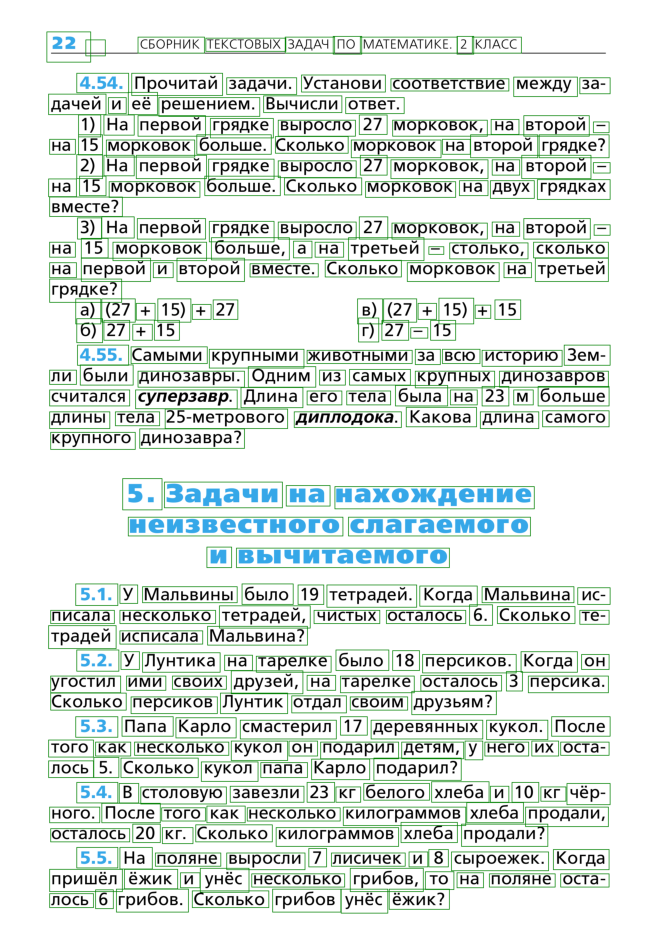

ED:      35
ED_norm: 0.9894

CER:     0.0211
WER:     0.0791

--------------------------------------------------------------------------------
Ground Truth (c:1657, w:278)
СБОРНИК ТЕКСТОВЫХ ЗАДАЧ ПО МАТЕМАТИКЕ. 2 КЛАСС
22
4.54. Прочитай задачи. Установи соответствие между за-
дачей и её решением. Вычисли ответ.
1) На первой грядке выросло 27 морковок, на второй –
на 15 морковок больше. Сколько морковок на второй грядке?
2) На первой грядке выросло 27 морковок, на второй –
на 15 морковок больше. Сколько морковок на двух грядках
вместе?
3) На первой грядке выросло 27 морковок, на второй –
на 15 морковок больше, а на третьей – столько, сколько
на первой и второй вместе. Сколько морковок на третьей
грядке?
а) (27 + 15) + 27
б) 27 + 15
в) (27 + 15) + 15
г) 27 – 15
4.55. Самыми крупными животными за всю историю Зем-
ли были динозавры. Одним из самых крупных динозавров
считался суперзавр. Длина его тела была на 23 м больше
длины тела 25‑метрового диплодока. Какова длина самого
крупного диноза

In [92]:
get_predict_doctr(model, CFG.path_dataset_documents, 'zadachi_page0020.png', image_size=12)

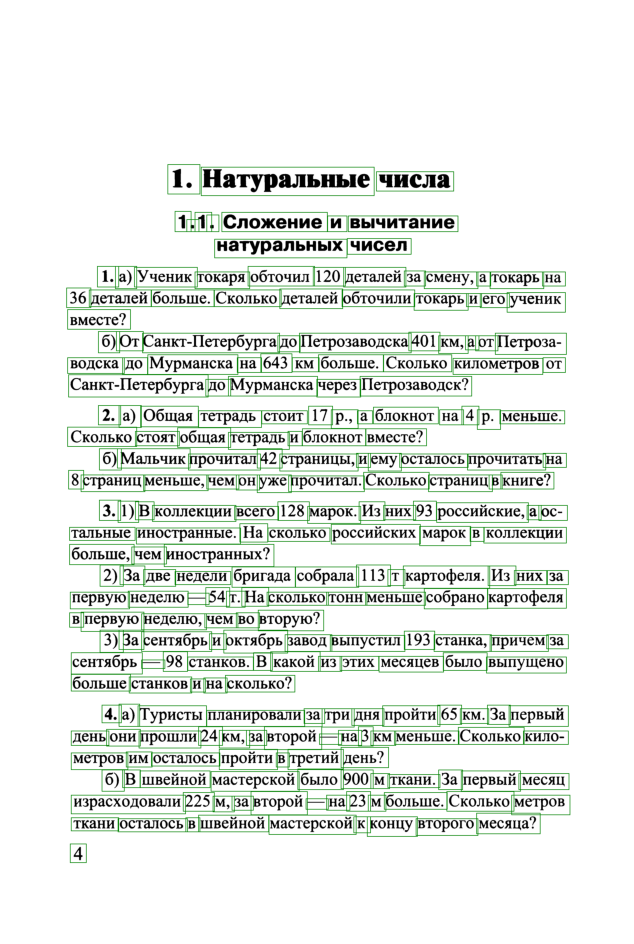

ED:      21
ED_norm: 0.9926

CER:     0.0149
WER:     0.0820

--------------------------------------------------------------------------------
Ground Truth (c:1408, w:244)
1. Натуральные числа
1.1. Сложение и вычитание
натуральных чисел
1. а) Ученик токаря обточил 120 деталей за смену, а токарь на
36 деталей больше. Сколько деталей обточили токарь и его ученик
вместе?
б) От Санкт-Петербурга до Петрозаводска 401 км, а от Петроза-
водска до Мурманска на 643 км больше. Сколько километров от
Санкт-Петербурга до Мурманска через Петрозаводск?
2. а) Общая тетрадь стоит 17 р., а блокнот на 4 р. меньше.
Сколько стоят общая тетрадь и блокнот вместе?
б) Мальчик прочитал 42 страницы, и ему осталось прочитать на
8 страниц меньше, чем он уже прочитал. Сколько страниц в книге?
3. 1) В коллекции всего 128 марок. Из них 93 российские, а ос-
тальные иностранные. На сколько российских марок в коллекции
больше, чем иностранных?
2) За две недели бригада собрала 113 т картофеля. Из них за
первую неделю — 54

In [98]:
get_predict_doctr(model, CFG.path_dataset_documents, 'book_page0004.png', image_size=12)

Но на более сложных текстах, где, к примеру, присутствуют формулы и таблицы точность оставляет желать лучшего.

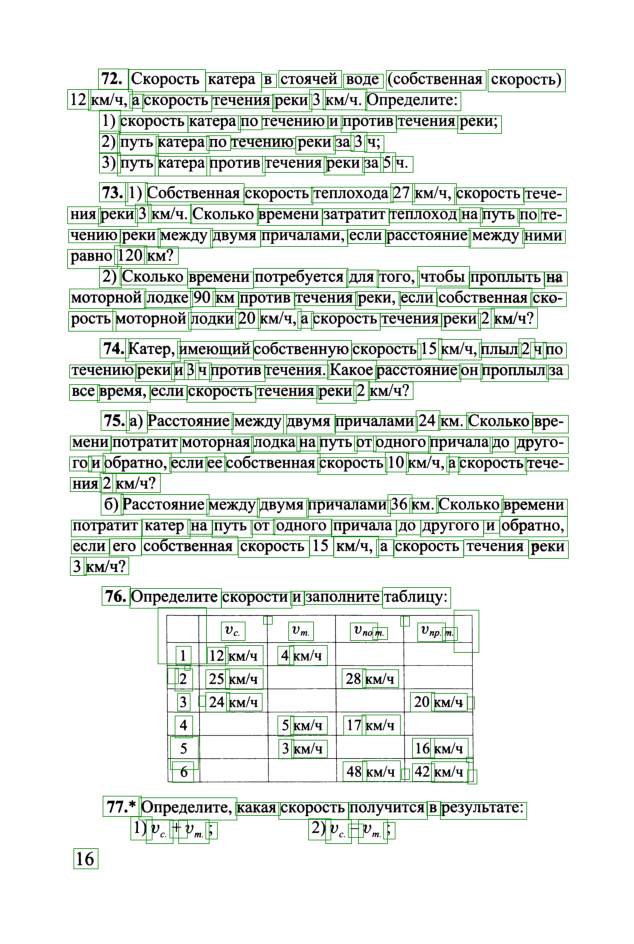

ED:      123
ED_norm: 0.9587

CER:     0.0834
WER:     0.2127

--------------------------------------------------------------------------------
Ground Truth (c:1474, w:268)
72. Скорость катера в стоячей воде (собственная скорость)
12 км/ч, а скорость течения реки 3 км/ч. Определите:
1) скорость катера по течению и против течения реки;
2) путь катера по течению реки за 3 ч;
3) путь катера против течения реки за 5 ч.
73. 1) Собственная скорость теплохода 27 км/ч, скорость тече-
ния реки 3 км/ч. Сколько времени затратит теплоход на путь по те-
чению реки между двумя причалами, если расстояние между ними
равно 120 км?
2) Сколько времени потребуется для того, чтобы проплыть на
моторной лодке 90 км против течения реки, если собственная ско-
рость моторной лодки 20 км/ч, а скорость течения реки 2 км/ч?
74. Катер, имеющий собственную скорость 15 км/ч, плыл 2 ч по
течению реки и 3 ч против течения. Какое расстояние он проплыл за
все время, если скорость течения реки 2 км/ч?
75. а) Расстояние ме

In [100]:
get_predict_doctr(model, CFG.path_dataset_documents, 'book_page0016.png', image_size=12)

Видно, что на данном примере модель с текстом справилась неплохо, но на блоке с таблицей много ошибок. В данном аспекте модель требует доработок.  
Но тем не менее, мы получили среднюю метрику **WER: 0.1137** на всем тестовом датасете, что довольно неплохо, учитывая что с таблицами и формулами модель не была обучена работать, и с простым текстом она справилась бы лучше.

In [101]:
# # Получаем список всех изображений тестового датасета
# with open(CFG.path_dataset_documents / 'labels.json', 'r', encoding='utf-8') as file:
#     labels = json.load(file)
# img_names = list(labels.keys())

# random_images = np.random.choice(img_names, 3)
# for img_name in random_images:
#     get_predict_doctr(model, CFG.path_dataset_documents, img_name, image_size=12)